(50000, 28, 28) (50000,)


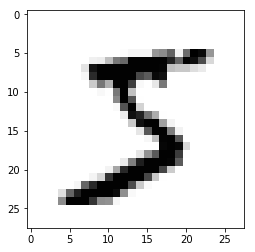

In [197]:
import sys
sys.path += ['week2']

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [198]:
from scipy.misc import imrotate, imresize

In [199]:
import tensorflow as tf
import numpy as np

# Data inspection and preparation

We first take a look at the data.

In [200]:
X_train.shape

(50000, 28, 28)

In [201]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [202]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [203]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[ -1.07063516e-03,   1.01924525e-03,  -3.15497949e-04, ...,
          1.41134404e-03,   1.42923580e-03,   2.88753479e-04],
       [ -2.59294931e-04,  -7.06813880e-04,   3.48278496e-04, ...,
         -4.47247614e-04,  -2.61874142e-04,  -3.42961634e-04],
       [ -1.19051384e-03,  -1.18666969e-03,  -8.02398834e-04, ...,
         -3.99876386e-04,  -1.40543957e-03,  -1.34161208e-03],
       ..., 
       [  1.35900464e-03,  -4.62068536e-04,  -2.14924221e-03, ...,
         -3.53883981e-04,   4.54994115e-05,  -6.56300050e-04],
       [  1.58797030e-03,  -1.79542718e-03,  -1.66833517e-04, ...,
          8.69987241e-04,  -2.36040796e-04,   1.13178138e-03],
       [  2.02801707e-03,   1.78744187e-04,  -7.66805257e-04, ...,
         -3.17415659e-04,   5.46147385e-05,  -1.83779607e-03]], dtype=float32), array([  3.79900594e-04,   1.08640437e-04,   2.64836330e-04,
         2.45067262e-04,   5.25927462e-04,   6.67279295e-04,
         3.18520440e-04,   1.96937326e-04,   7.58414317e-05,
      

Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [204]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[ -1.07063516e-03,   1.01924525e-03,  -3.15497949e-04, ...,
           1.41134404e-03,   1.42923580e-03,   2.88753479e-04],
        [ -2.59294931e-04,  -7.06813880e-04,   3.48278496e-04, ...,
          -4.47247614e-04,  -2.61874142e-04,  -3.42961634e-04],
        [ -1.19051384e-03,  -1.18666969e-03,  -8.02398834e-04, ...,
          -3.99876386e-04,  -1.40543957e-03,  -1.34161208e-03],
        ..., 
        [  1.35900464e-03,  -4.62068536e-04,  -2.14924221e-03, ...,
          -3.53883981e-04,   4.54994115e-05,  -6.56300050e-04],
        [  1.58797030e-03,  -1.79542718e-03,  -1.66833517e-04, ...,
           8.69987241e-04,  -2.36040796e-04,   1.13178138e-03],
        [  2.02801707e-03,   1.78744187e-04,  -7.66805257e-04, ...,
          -3.17415659e-04,   5.46147385e-05,  -1.83779607e-03]], dtype=float32),
 array([  3.79900594e-04,   1.08640437e-04,   2.64836330e-04,
          2.45067262e-04,   5.25927462e-04,   6.67279295e-04,
          3.18520440e-04,   1.96937326e-04,   7.58414

Finally, compute accuracy metrics when training the network. We train the network for 30 iterations, and log training and validation accuracy as we go along. Finally, we compute the final score using the test accuracy.

In [205]:
s.run(tf.global_variables_initializer())

losses = []
train_accuracies = []
validation_accuracies = []

for i in range(30):
    loss_i, accuracy_i, _ = s.run([loss, accuracy, optimizer], 
                                  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [accuracy_i]
    validation_accuracies += [s.run(accuracy, {input_X:X_val, input_y: y_val})]

test_accuracy = s.run(accuracy, {input_X:X_test, input_y: y_test})
print("Final test accuracy: {:.2f}".format(test_accuracy))

Final test accuracy: 0.80


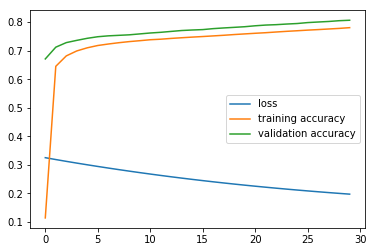

In [206]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(validation_accuracies);
plt.legend(['loss', 'training accuracy', 'validation accuracy'])


As we can see, the network is not really good at all.

Next, we create a generator that will provide us with randomized minibatches, to do incremental training. The class takes an X and a y input array, and will provide shuffled batches until it covers the whole input, at which point it reshuffles the input again and provides more randomized batches.

In [207]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.idxs = np.array(idxs, dtype=np.int32)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_idxs = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_idxs = self.idxs[self.current_i:]
            self.reshuffle()
            res_idxs = np.append(res_idxs, self.idxs[:rem], axis=0)
            self.current_i = rem
        else:
            res_idxs = self.idxs[self.current_i:end_i]
            self.current_i = end_i

        return self.X[res_idxs], self.y[res_idxs]

The helper method train_network allows us to train a network and plot the training graphs, while varying iterations and batch_sizes. It's mostly here to save on typing.

In [208]:
def train_network(iterations=2000, batch_size=1000, X_train=X_train, y_train=y_train):
    s.run(tf.global_variables_initializer())

    batcher = MiniBatchGenerator(X_train, y_train, batch_size)

    losses = []
    batch_train_accuracies = []

    val_accuracies = []
    test_accuracies = []

    for i in range(iterations):
        X_batch, y_batch = batcher.next()

        loss_i, accuracy_i, optimizer_i = s.run([
            loss, accuracy, optimizer
        ],  {input_x: X_batch, 
                         label_y: y_batch})

        if i % 100 == 0:        
            losses += [loss_i]
            batch_train_accuracies += [accuracy_i]

            val_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_val, 
                 label_y: y_val})
            val_accuracies += [val_accuracy_i]

            test_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_test, 
                 label_y: y_test})
            test_accuracies += [test_accuracy_i]

            print("{} - loss: {}, train: {}, val: {}, test: {}".format(
                i, loss_i, accuracy_i, val_accuracy_i, test_accuracy_i))

    plt.figure()
    plt.plot(losses);
    plt.plot(batch_train_accuracies)
    plt.plot(val_accuracies)
    plt.plot(test_accuracies);
    plt.legend(['loss', 'batch train accuracy', 'validation accuracy', 'test accuracy'])

    l = len(batch_train_accuracies) - 20
    
    plt.figure()
    plt.plot(batch_train_accuracies[-l:])
    plt.plot(test_accuracies[-l:]);
    plt.legend(['batch training accuracy', 'test accuracy'])

## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [209]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

layer_cnt = 0

def add_layer(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    layer_cnt += 1
    return y2

hidden_size = 30

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = 1

    # input layer
    y1 = add_layer(x, 50, tf.nn.sigmoid, sigma=sigma)
    # output layer
    y = add_layer(y1, 10, tf.nn.softmax, sigma=sigma)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)


0 - loss: 6.320565700531006, train: 0.14000000059604645, val: 0.1168999969959259, test: 0.11459999531507492
100 - loss: 0.6871140599250793, train: 0.7850000262260437, val: 0.8331000804901123, test: 0.8263000249862671
200 - loss: 0.422717422246933, train: 0.8640000820159912, val: 0.8735000491142273, test: 0.8661000728607178
300 - loss: 0.4071812629699707, train: 0.8780000805854797, val: 0.888200044631958, test: 0.8812001943588257
400 - loss: 0.4233894348144531, train: 0.8670000433921814, val: 0.9003000855445862, test: 0.8920000195503235
500 - loss: 0.30619367957115173, train: 0.9150000810623169, val: 0.9079000353813171, test: 0.8996000289916992
600 - loss: 0.3301517963409424, train: 0.9070000648498535, val: 0.9110000729560852, test: 0.9054000377655029
700 - loss: 0.27752476930618286, train: 0.9180000424385071, val: 0.9166001081466675, test: 0.9087001085281372
800 - loss: 0.2698349952697754, train: 0.9230000376701355, val: 0.9195000529289246, test: 0.9124001264572144
900 - loss: 0.283127

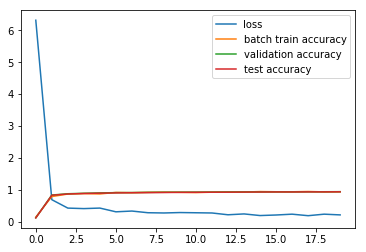

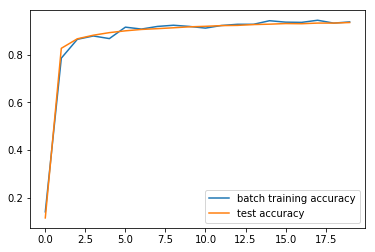

In [210]:
train_network()

As we can see, this network is already much better, but it still is not better than logistic regression. We can train for longer, add more layers, tweak the learning rate and the batch sizes, which I have done in excruciating detail. However, I will only provide the final solution. What I did was expand the training set by rotating images back and forth, and resizing them. This allows us to have way more training data, which is quite beneficial. So in this segment, we generate an `expanded_X_train` that has rotate and scaled images. 

## Warning on coursera

This takes quite a while to run because I haven't tried to remotely optimize it. It's better to just run the network on the original training set on coursera because the kernel tends to crash because it doesn't have enough memory.

In [211]:
expanded_X_train = []
expanded_y_train = []

def img_resize(img, percent):
    img_ = imresize(img, percent)
    offset = int((img_.shape[0] - 28) / 2)
    return img_[offset:offset+28, offset:offset+28]

for i in range(len(X_train)):
    img = X_train[i]
    img_class = y_train[i]

    expanded_X_train += [img]
    expanded_y_train += [img_class]

    # use the commented out lines for a bigger dataset.
#     for angle in [5, -5, 10, -10, -15, 15, -20, 20]:
    for angle in [10, -10]:
        img_ = imrotate(img, angle) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
#     for scale in [120, 110]:
#         img_ = img_resize(img, scale) / 255.
#         assert img_.shape[0] == 28
#         expanded_X_train += [img_]
#         expanded_y_train += [img_class]
    
expanded_X_train = np.array(expanded_X_train)
expanded_y_train = np.array(expanded_y_train)


Here is the transformed versions of the first digit:

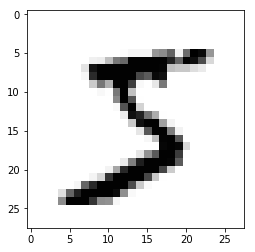

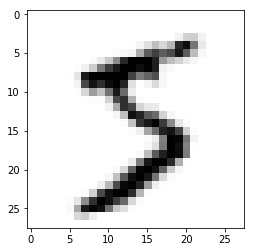

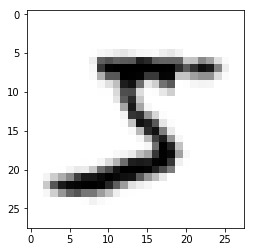

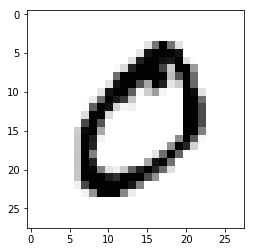

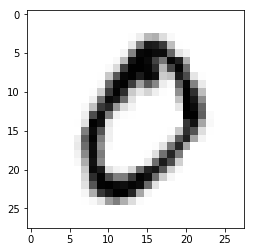

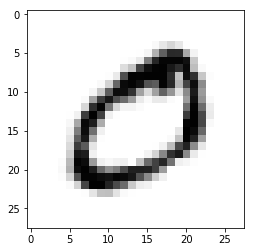

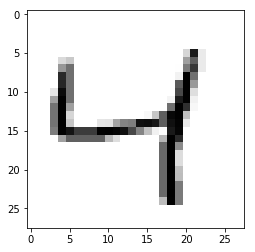

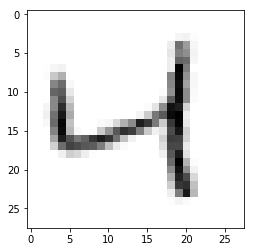

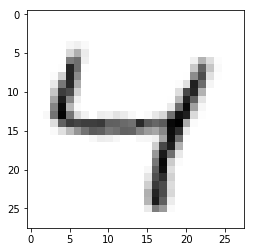

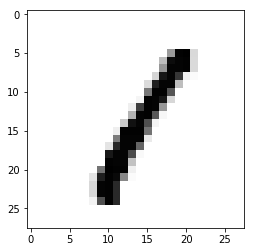

In [212]:
for i in range(10):
    plt.figure()
    plt.imshow(expanded_X_train[i], cmap="Greys");

## Multilayer neural network with higher accuracy

Finally, we use fairly simple 3 layer neural network. An important change I did was to add a L2 loss to every layer, so that we avoid overfitting on the training set. I played around with different metrics and initialization standard deviation and learning rate, but this setup seems to reliably achieve a stable 98% accuracy, so that's what I'm submitting.

In [213]:
tf.reset_default_graph()
s = tf.InteractiveSession()

def add_layer_with_loss(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    loss = tf.norm(W2, ord=2)
#     loss = tf.reduce_sum(tf.sqrt(tf.tensordot(tf.squeeze(W2), tf.squeeze(W2), 1)))
#     loss += tf.reduce_sum(tf.sqrt(tf.tensordot(b2, b2, 1)))
    
    layer_cnt += 1
    return y2, loss


with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = .1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.005
    
    y1, loss_ = add_layer_with_loss(x, 100, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y3, loss_ = add_layer_with_loss(y1, 50, tf.nn.relu, sigma=sigma)
    loss += loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y3, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)

    
    s.run(tf.global_variables_initializer())

# train_network(iterations=5000, batch_size=1000, X_train=X_train, y_train=y_train)

sigma 0.1


Training the network for 20000 iterations on a batch size of 100, which takes about 30 seconds on my computer, gives us a reliably and not overfitted 98% accuracy (when using the expanded input train).

## Warning on coursera

This uses the expanded training set computed above. For best results, it's best to enable all rotations and scalings, but even just a few rotations help a lot. If coursera crashes on you, don't do the data manipulation, and use the version below for training on the original data set. This won't reach 98% however.

0 - loss: 2.5469534397125244, train: 0.059999994933605194, val: 0.15889999270439148, test: 0.16509999334812164
100 - loss: 0.6219174861907959, train: 0.8799999952316284, val: 0.8842000961303711, test: 0.8802000284194946
200 - loss: 0.5244939923286438, train: 0.9200000166893005, val: 0.9025001525878906, test: 0.9003000855445862
300 - loss: 0.5951281785964966, train: 0.89000004529953, val: 0.9238001108169556, test: 0.9176000356674194
400 - loss: 0.6519646644592285, train: 0.8700000047683716, val: 0.9300001263618469, test: 0.9247000813484192
500 - loss: 0.4178043603897095, train: 0.9399999976158142, val: 0.9364001154899597, test: 0.9351001977920532
600 - loss: 0.31200483441352844, train: 0.9800000190734863, val: 0.9386001229286194, test: 0.9364000558853149
700 - loss: 0.27749109268188477, train: 0.9899999499320984, val: 0.9500001668930054, test: 0.9467000961303711
800 - loss: 0.4771512448787689, train: 0.9399999976158142, val: 0.9517002105712891, test: 0.9477001428604126
900 - loss: 0.400

7500 - loss: 0.25667327642440796, train: 0.9700000286102295, val: 0.9775001406669617, test: 0.9770001769065857
7600 - loss: 0.21696467697620392, train: 0.9999999403953552, val: 0.9790001511573792, test: 0.9782001376152039
7700 - loss: 0.3294410705566406, train: 0.9699999690055847, val: 0.9772001504898071, test: 0.9781001210212708
7800 - loss: 0.274585485458374, train: 0.9799999594688416, val: 0.9758001565933228, test: 0.9763001799583435
7900 - loss: 0.2607271373271942, train: 0.9899999499320984, val: 0.9787001609802246, test: 0.9799001216888428
8000 - loss: 0.22808358073234558, train: 0.9900000095367432, val: 0.978900134563446, test: 0.9796000719070435
8100 - loss: 0.23301032185554504, train: 0.9899999499320984, val: 0.9801002144813538, test: 0.9807000756263733
8200 - loss: 0.24783039093017578, train: 0.9799999594688416, val: 0.9796000719070435, test: 0.9788001179695129
8300 - loss: 0.25727543234825134, train: 0.9700000286102295, val: 0.9774001836776733, test: 0.9779002070426941
8400 -

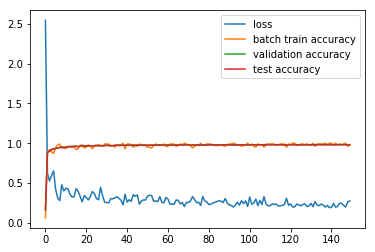

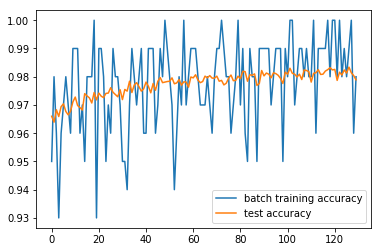

In [214]:
train_network(iterations=15000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)

## Run this if coursera crashes

This version uses the original data set, and only trains to 97.5% accuracy usually, because the training set is smaller. It also overfits much more.

0 - loss: 2.597395896911621, train: 0.08999999612569809, val: 0.11290000379085541, test: 0.11749999225139618
100 - loss: 0.6196253299713135, train: 0.8499999642372131, val: 0.8520000576972961, test: 0.8481001257896423
200 - loss: 0.6300174593925476, train: 0.8700000047683716, val: 0.9169001579284668, test: 0.9164000749588013
300 - loss: 0.5022561550140381, train: 0.9000000357627869, val: 0.9285001158714294, test: 0.9248001575469971
400 - loss: 0.591055154800415, train: 0.9100000262260437, val: 0.9170001149177551, test: 0.9131001234054565
500 - loss: 0.37832948565483093, train: 0.9599999785423279, val: 0.9425000548362732, test: 0.9402000904083252
600 - loss: 0.4459834694862366, train: 0.9100000262260437, val: 0.9386000633239746, test: 0.9370000958442688
700 - loss: 0.38788822293281555, train: 0.9399999380111694, val: 0.9454001784324646, test: 0.9439000487327576
800 - loss: 0.3651098906993866, train: 0.9500000476837158, val: 0.9525001645088196, test: 0.9505000710487366
900 - loss: 0.3366

7600 - loss: 0.21592195332050323, train: 0.9999999403953552, val: 0.9764001965522766, test: 0.976000189781189
7700 - loss: 0.2292466163635254, train: 0.9899999499320984, val: 0.9751001000404358, test: 0.9756001830101013
7800 - loss: 0.2539122700691223, train: 0.9900000095367432, val: 0.97350013256073, test: 0.9736000895500183
7900 - loss: 0.3041188716888428, train: 0.9599999785423279, val: 0.9758000373840332, test: 0.9742001295089722
8000 - loss: 0.22542667388916016, train: 0.9800000190734863, val: 0.9757000803947449, test: 0.9765000939369202
8100 - loss: 0.215900719165802, train: 0.9899999499320984, val: 0.9728001356124878, test: 0.9706000685691833
8200 - loss: 0.2237548828125, train: 0.9900000095367432, val: 0.9780001640319824, test: 0.9777001738548279
8300 - loss: 0.24697619676589966, train: 0.9799999594688416, val: 0.9752001166343689, test: 0.9780001640319824
8400 - loss: 0.22682659327983856, train: 1.0, val: 0.9774000644683838, test: 0.978300154209137
8500 - loss: 0.20821110904216

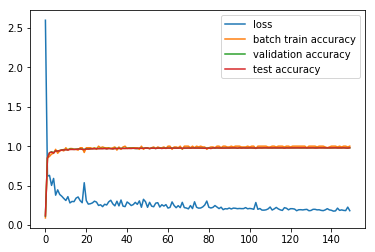

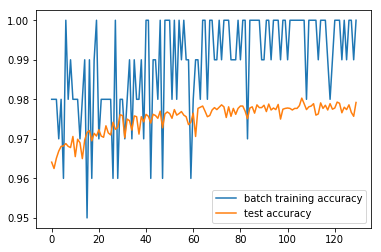

In [215]:
train_network(iterations=15000, batch_size=100, X_train=X_train, y_train=y_train)